In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import utils

In [2]:
WINDOW_SIZE = 24
BATCH_SIZE = 32
LABEL_NAME = 'T (degC)'

In [3]:
df_train, df_val, df_test = utils.load_data()
print(f"df_train.shape = {df_train.shape}, df_val.shape = {df_val.shape}, df_test.shape = {df_test.shape}")
df_train.head()

df_train.shape = (49063, 19), df_val.shape = (14018, 19), df_test.shape = (7010, 19)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,-1.366064,-0.366026,-0.069373,1.427981
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,-1.414249,0.000015,-0.068349,1.427977
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,-1.366064,0.366057,-0.067326,1.427971
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,-1.224793,0.707153,-0.066303,1.427965
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,-1.000062,1.000060,-0.065280,1.427958


In [4]:
label_idx = list(df_train.columns).index(LABEL_NAME)

In [5]:
def build_dataset(df_data, window_size, batch_size, label_idx, shuffle=True):
    data = np.array(df_data, dtype=np.float32)
    ds = keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=window_size + 1,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    # Note: Use batched_window[:, 1: ...
    ds = ds.map(lambda batched_window: (batched_window[:, :-1, :], batched_window[:, 1:, label_idx:label_idx+1]))
    return ds

In [6]:
train_ds = build_dataset(df_train, WINDOW_SIZE, BATCH_SIZE, label_idx, shuffle=False)

for x_batch, y_batch in train_ds.take(1):
    print(f"x_batch.shape = {x_batch.shape}")
    print(f"x_batch[0, :3] = \n{x_batch[0, :3]}")
    print(f"y_batch.shape = {y_batch.shape}")
    print(f"y_batch[0, :3] = \n{y_batch[0, :3]}")

x_batch.shape = (32, 24, 19)
x_batch[0, :3] = 
[[ 9.45307612e-01 -1.98247325e+00 -2.04188848e+00 -1.91897273e+00
   1.11710155e+00 -1.30285120e+00 -1.47732317e+00 -7.90423632e-01
  -1.48003638e+00 -1.48269725e+00  2.21852374e+00  1.93409234e-01
   2.21161291e-01  1.11140452e-01  2.17927873e-01 -1.36606407e+00
  -3.66026342e-01 -6.93725795e-02  1.42798138e+00]
 [ 9.59769845e-01 -2.07837200e+00 -2.13816643e+00 -2.06096363e+00
   1.04461730e+00 -1.33014262e+00 -1.53435397e+00 -7.86272287e-01
  -1.53618979e+00 -1.53903449e+00  2.32570744e+00  1.72986776e-01
   2.22100869e-01  1.09458245e-01  2.27798492e-01 -1.41424906e+00
   1.52973589e-05 -6.83494657e-02  1.42797673e+00]
 [ 9.86283958e-01 -2.07028437e+00 -2.13243556e+00 -2.04518700e+00
   1.06273842e+00 -1.32884300e+00 -1.52722502e+00 -7.88347960e-01
  -1.52870274e+00 -1.53199232e+00  2.32399845e+00  2.07982704e-01
   2.76266009e-01  1.11218050e-01  3.24078411e-01 -1.36606407e+00
   3.66056949e-01 -6.73263520e-02  1.42797124e+00]]
y_batch

In [7]:
train_ds = build_dataset(df_train, WINDOW_SIZE, BATCH_SIZE, label_idx)
val_ds = build_dataset(df_val, WINDOW_SIZE, BATCH_SIZE, label_idx)

In [8]:
model = keras.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)

history = model.fit(
    train_ds, 
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/20
1533/1533 [==============================] - 10s 7ms/step - loss: 0.0244 - mean_absolute_error: 0.0891 - val_loss: 0.0066 - val_mean_absolute_error: 0.0571
Epoch 2/20
1533/1533 [==============================] - 12s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0556 - val_loss: 0.0060 - val_mean_absolute_error: 0.0536
Epoch 3/20
1533/1533 [==============================] - 12s 8ms/step - loss: 0.0060 - mean_absolute_error: 0.0535 - val_loss: 0.0058 - val_mean_absolute_error: 0.0529
Epoch 4/20
1533/1533 [==============================] - 12s 8ms/step - loss: 0.0058 - mean_absolute_error: 0.0527 - val_loss: 0.0056 - val_mean_absolute_error: 0.0515
Epoch 5/20
1533/1533 [==============================] - 12s 8ms/step - loss: 0.0056 - mean_absolute_error: 0.0519 - val_loss: 0.0057 - val_mean_absolute_error: 0.0524
Epoch 6/20
1533/1533 [==============================] - 13s 8ms/step - loss: 0.0055 - mean_absolute_error: 0.0514 - val_loss: 0.0056 - val_mean_absolute_error: 0.051

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 32)          6656      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


In [10]:
forecast_period = range(24)
actual = []
forecasts = []

for i in forecast_period:
    new_data = df_val.iloc[i:i + WINDOW_SIZE].to_numpy()
    new_data = np.expand_dims(new_data, 0)
    forecast = model.predict(new_data)
    forecast = tf.squeeze(forecast).numpy()[-1]
    forecasts.append(forecast)
    actual.append(df_val.iloc[i + WINDOW_SIZE][LABEL_NAME])

In [11]:
utils.evaluate(actual, forecasts)

mse = 0.0034, mae = 0.0405


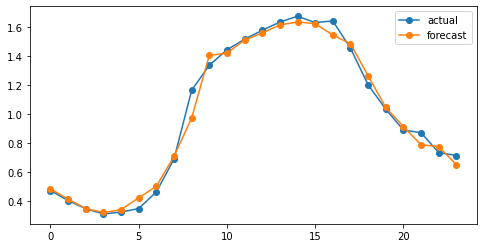

In [12]:
utils.plot_result(actual, forecasts)